# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [2]:
import sys
sys.path.append("..")
import grading
import download_utils

In [3]:
download_utils.link_all_keras_resources()

In [4]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

# Prepare the storage for model checkpoints

In [5]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = False

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

/root/intro-to-dl/week6/weights_10


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [6]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [7]:
# token expires every 30 min
COURSERA_TOKEN = '-'
COURSERA_EMAIL = 'gmail.com'

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [8]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [9]:
IMG_SIZE = 299

In [10]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(inputs=model.inputs, outputs=keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [11]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [12]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [13]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


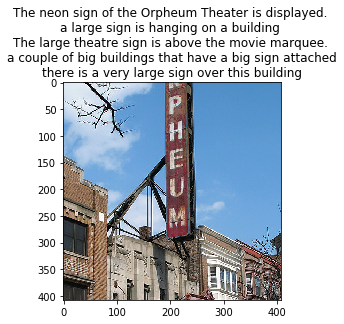

In [14]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=19)

# Prepare captions for training

In [15]:
# preview captions data
train_captions[:2]
print(np.array(train_captions).shape)

(82783,)


In [16]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    ### YOUR CODE HERE ###
    train_captions = [split_sentence(sentence) for im in train_captions for sentence in im]
    # flatten 
    train_captions = [item for sublist in train_captions for item in sublist]
    # add specials
    specials = [PAD, UNK, START, END]
    train_captions += specials
    tokens, cnts = np.unique(train_captions, return_counts=True)
    tokens = [tokens[i] for i in range(len(tokens)) if cnts[i] >= 5 or tokens[i] in specials]
    
    train_captions = {token: index for index, token in enumerate(sorted(tokens))}
    
    return train_captions

def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    def apply_on_sentence(sentence):
        sentence = split_sentence(sentence)  # it is now a list
        apply_on_word = lambda word: vocab[word] if word in vocab else vocab[UNK]
        sentence = [vocab[START]] + [apply_on_word(word) for word in sentence] + [vocab[END]]   
        return sentence
    
    for i in range(len(captions)):
        captions[i] = [apply_on_sentence(sentence) for sentence in captions[i]]
    

    return captions

In [17]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [18]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)
print(train_captions_indexed[:2])
train_captions[:2]


[[[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0], [2, 54, 6540, 5127, 8486, 249, 54, 5437, 8507, 0], [2, 54, 6502, 5437, 7581, 1124, 8052, 4287, 7905, 54, 639, 0], [2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0], [2, 2305, 5437, 4286, 710, 587, 8052, 7905, 5174, 5684, 0]], [[2, 54, 3484, 5127, 8755, 7296, 5025, 7905, 2540, 5222, 0], [2, 7835, 3998, 242, 3877, 5127, 5127, 8756, 2468, 0], [2, 8756, 249, 764, 6709, 7804, 6484, 8492, 3738, 0], [2, 8756, 7800, 330, 711, 5254, 249, 2468, 8486, 7919, 0], [2, 54, 5072, 5127, 8756, 2468, 8486, 4975, 5159, 269, 0]]]


[[[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0],
  [2, 54, 6540, 5127, 8486, 249, 54, 5437, 8507, 0],
  [2, 54, 6502, 5437, 7581, 1124, 8052, 4287, 7905, 54, 639, 0],
  [2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0],
  [2, 2305, 5437, 4286, 710, 587, 8052, 7905, 5174, 5684, 0]],
 [[2, 54, 3484, 5127, 8755, 7296, 5025, 7905, 2540, 5222, 0],
  [2, 7835, 3998, 242, 3877, 5127, 5127, 8756, 2468, 0],
  [2, 8756, 249, 764, 6709, 7804, 6484, 8492, 3738, 0],
  [2, 8756, 7800, 330, 711, 5254, 249, 2468, 8486, 7919, 0],
  [2, 54, 5072, 5127, 8756, 2468, 8486, 4975, 5159, 269, 0]]]

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [19]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx=vocab[PAD], max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    sample_maxlen = max(map(len, batch_captions))
    m = sample_maxlen if max_len is None else min(sample_maxlen, max_len)
    
    def apply_on_sentence(sentence):
        l = len(sentence)
        if l == m:
            return sentence
        elif l > m:
            return sentence[:m]
        else:
            return np.pad(sentence, pad_width=(0, m-l), constant_values=pad_idx)
    
    return np.array([apply_on_sentence(caption) for caption in batch_captions])

In [20]:
print(np.array(train_captions[:2]).shape)
np.array(batch_captions_to_matrix(train_captions[:2], max_len=1000)).shape

(2, 5)


(2, 5)

In [21]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [22]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


In [23]:
#print(sorted(vocab.values()))

# make sure you use correct argument in caption_tokens_to_indices
#assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
#assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [24]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [25]:
IMG_EMBED_SIZE

2048

In [26]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="images/flatten_help.jpg" style="width:80%">

In [27]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(input_dim=len(vocab), output_dim=WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(units=len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    # YOUR CODE HERE #
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    ### YOUR CODE HERE ###
    word_embeds = word_embed(sentences[:, :-1])  # omit last
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(cell=lstm, inputs=word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    ### YOUR CODE HERE ###
    flat_hidden_states = tf.reshape(hidden_states, (-1, LSTM_UNITS))

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    ### YOUR CODE HERE ###
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    ### YOUR CODE HERE ###
    flat_ground_truth = tf.reshape(sentences[:, 1:], (-1, )) 
    
    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    ### YOUR CODE HERE ###
    flat_loss_mask = tf.not_equal( flat_ground_truth , pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )
    print(xent)
    print(flat_loss_mask)

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    ### YOUR CODE HERE ###
    loss = tf.reduce_mean(tf.boolean_mask(tensor=xent, mask=flat_loss_mask))

Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("NotEqual:0", shape=(?,), dtype=bool)


In [28]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [29]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [30]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [31]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [32]:
import random
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    ids = np.random.choice(np.arange(images_embeddings.shape[0]), batch_size)
    batch_image_embeddings = images_embeddings[ids]
    batch_captions = indexed_captions[ids]
    selected_batch_captions = []
    
    for i in batch_captions:
        selected_batch_captions += [np.array(random.sample(i, 1)[0])]
        
    batch_captions_matrix = batch_captions_to_matrix(np.array(selected_batch_captions), max_len=max_len)
    
    assert batch_image_embeddings.shape[0] == batch_captions_matrix.shape[0]
   # print(batch_captions_matrix)
   # for i in batch_captions_matrix.flatten():
    #    assert i in vocab.keys()
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

aux = train_captions_indexed[np.random.choice(np.arange(len(train_captions_indexed)), 200)]
for i in aux:
    print(i)
    print('CHoice', np.array(random.sample(i, 1)[0]), '\n')

[[2, 119, 3450, 1288, 4515, 5155, 871, 3885, 8665, 872, 0], [2, 54, 1288, 7800, 3998, 4278, 2414, 5155, 871, 0], [2, 54, 1288, 4278, 5155, 7953, 5127, 54, 6739, 5127, 871, 0], [2, 54, 8349, 2068, 1288, 4278, 5155, 7105, 871, 5155, 54, 6739, 0], [2, 54, 1288, 3998, 4278, 5155, 7953, 5127, 7105, 871, 5155, 54, 6739, 0]]
CHoice [   2   54 1288 4278 5155 7953 5127   54 6739 5127  871    0] 

[[2, 249, 2601, 3998, 7296, 5025, 7905, 8052, 249, 7823, 3078, 0], [2, 54, 4244, 2601, 3998, 6804, 8435, 4975, 7105, 8052, 249, 1015, 0], [2, 242, 2601, 8647, 8145, 8435, 7848, 54, 4083, 0], [2, 54, 8349, 1553, 8252, 8367, 5127, 54, 738, 2068, 2601, 0], [2, 242, 2601, 7296, 402, 54, 2194, 3107, 331, 0]]
CHoice [   2  242 2601 8647 8145 8435 7848   54 4083    0] 

[[2, 8000, 8103, 249, 1262, 330, 6888, 5155, 54, 4799, 6328, 0], [2, 54, 6179, 249, 3450, 5714, 7645, 8647, 1262, 5155, 4003, 0], [2, 2939, 8100, 3885, 3650, 8010, 5155, 54, 966, 1971, 269, 3697, 0], [2, 8000, 1262, 249, 8103, 5155, 54, 8000, 

CHoice [   2   54 4422 6372 8647 6861    3 8169 3208    0] 

[[2, 6675, 2282, 330, 6602, 402, 54, 6264, 7645, 0], [2, 54, 4558, 3736, 54, 1321, 5583, 6888, 402, 54, 7645, 8647, 5672, 249, 8620, 0], [2, 6675, 3159, 330, 6670, 345, 54, 2286, 7645, 0], [2, 5536, 6881, 402, 54, 7645, 8647, 3086, 249, 2469, 3885, 3175, 5127, 7809, 0], [2, 5536, 6888, 402, 54, 6264, 7645, 2563, 5672, 0]]
CHoice [   2 6675 3159  330 6670  345   54 2286 7645    0] 

[[2, 8165, 4244, 1299, 2468, 8486, 3173, 54, 7922, 0], [2, 8165, 777, 1299, 330, 2468, 5228, 5127, 54, 7922, 0], [2, 8165, 1299, 6888, 5155, 54, 7922, 6601, 2468, 7804, 8486, 0], [2, 8165, 1299, 2468, 5228, 5127, 54, 7922, 3885, 7804, 622, 0], [2, 8165, 2109, 1649, 1299, 2468, 3173, 54, 7922, 0]]
CHoice [   2 8165 4244 1299 2468 8486 3173   54 7922    0] 

[[2, 8165, 2373, 6888, 5155, 54, 5442, 7919, 0], [2, 8165, 4244, 2373, 4515, 5155, 8665, 3021, 5246, 0], [2, 8165, 2373, 4278, 2414, 5155, 54, 8664, 5809, 331, 0], [2, 8165, 2373, 4273, 5155, 54,

In [33]:
import random
ls = [[2, 54, 627, 3998, 402, 7804, 5704, 3885, 54, 598, 3229, 0], [2, 54, 5566, 3885, 54, 598, 8215, 3736, 54, 598, 614, 0], [2, 54, 4558, 3998, 3736, 54, 598, 614, 402, 54, 3229, 0], [2, 54, 627, 7296, 402, 7804, 5704, 8421, 3097, 7804, 5666, 0], [2, 54, 627, 402, 54, 598, 3229, 8421, 3097, 7804, 5666, 0]]
#ls = np.array(ls)
#print(ls.shape)
print(random.sample(ls, 1))

[[2, 54, 627, 7296, 402, 7804, 5704, 8421, 3097, 7804, 5666, 0]]


In [33]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [34]:
# you can load trained weights here
# uncomment the next line if you need to load weights
saver.restore(s, get_checkpoint_path(epoch=11))

INFO:tensorflow:Restoring parameters from /root/intro-to-dl/week6/weights_11


Look at the training and validation loss, they should be decreasing!


Epoch: 0, train loss: 4.328712641477585, val loss: 3.672979943752289


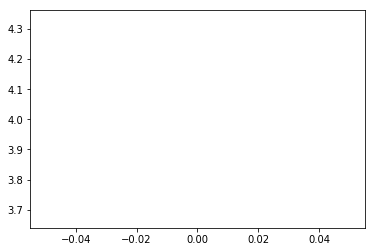


Epoch: 1, train loss: 3.360206561088562, val loss: 3.196179575920105


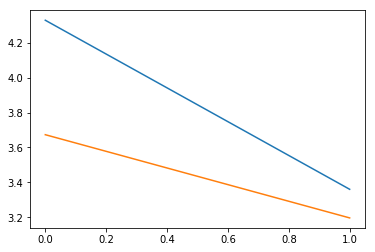


Epoch: 2, train loss: 3.051973536968231, val loss: 2.9853817677497863


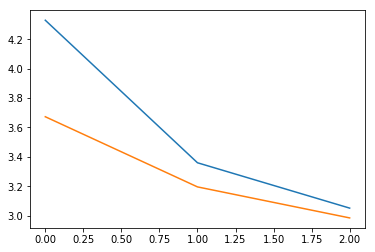


Epoch: 3, train loss: 2.9017562911510466, val loss: 2.917575418949127


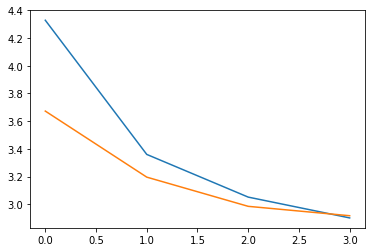


Epoch: 4, train loss: 2.8048866519927977, val loss: 2.8100415229797364


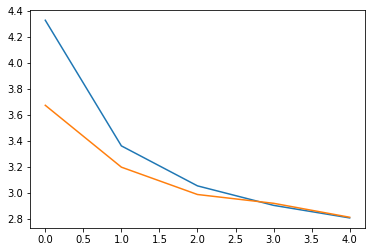


Epoch: 5, train loss: 2.731561142683029, val loss: 2.7813563752174377


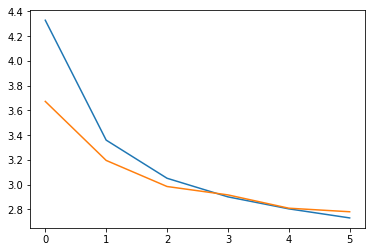


Epoch: 6, train loss: 2.6856984097957612, val loss: 2.7344519567489622


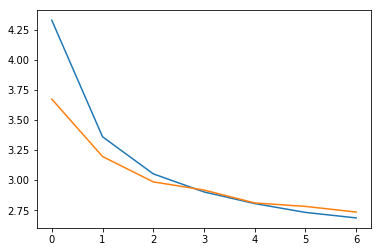


Epoch: 7, train loss: 2.6421853234767916, val loss: 2.716388943195343


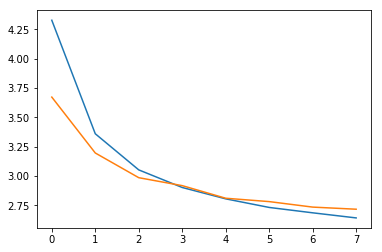


Epoch: 8, train loss: 2.606194131851196, val loss: 2.6485350370407104


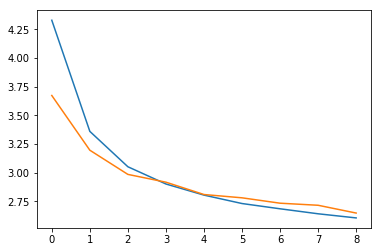


Epoch: 9, train loss: 2.5770513093471528, val loss: 2.6449725317955015


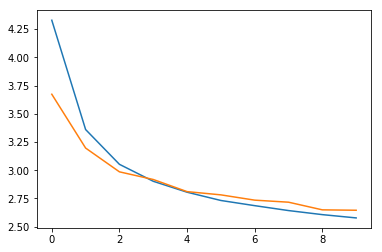


Epoch: 10, train loss: 2.5567793078422545, val loss: 2.647603213787079


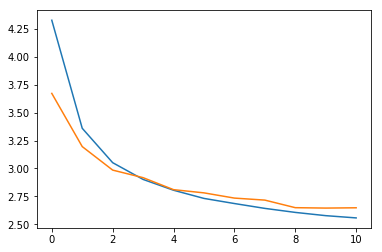


Epoch: 11, train loss: 2.519691272735596, val loss: 2.621015486717224


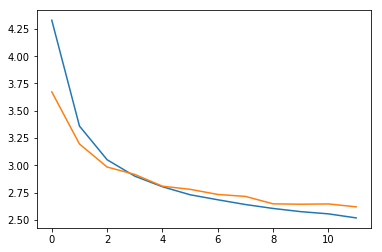

Finished!


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)
epoch_train= []
epoch_val = []
epochs = []

for epoch in range(n_epochs):
    epochs += [epoch]
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
        
    train_loss /= n_batches_per_epoch
    epoch_train += [train_loss]
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    epoch_val += [val_loss]
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    # plot
    plt.plot(epochs, epoch_train)
    plt.plot(epochs, epoch_val)
    plt.show()

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

In [37]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

In [39]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [43]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.5608723
Accuracy: 0.45901639344262296
Example 0
Predicted: a man with a sausages dogs and it #END# a other #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a grill with several hot dogs on it and some already cooked #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a brown bear white bear walking walking in a rock #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a brown and black bear is sleeping on a log #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a bus and a open and and next a bus #END# a city day #END# #END# #END# #END# #END#
Truth: a man in an orange vest stands near a bus on a foggy night #END# #PAD# #PAD# #PAD# #PAD#



In [44]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/root/intro-to-dl/week6/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [35]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /root/intro-to-dl/week6/weights


In [46]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [36]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player is swinging at a ball


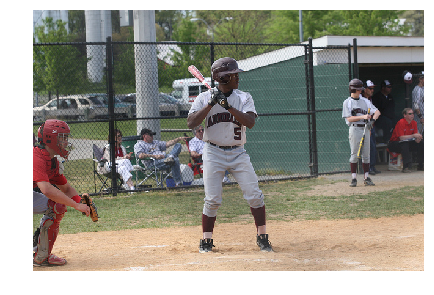

In [37]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a young boy is holding a frisbee in her hands


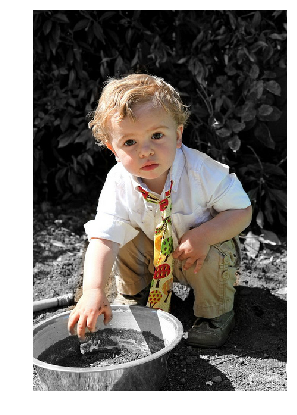

a cat is sleeping on a bed with a cat


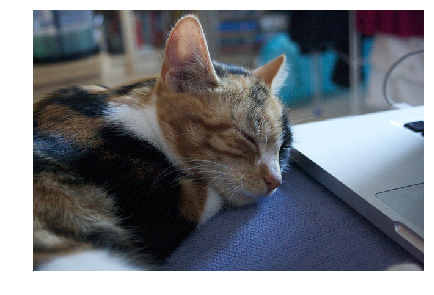

a pizza sitting on top of a stove top oven


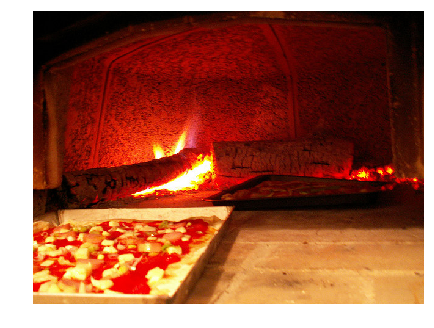

a clock on a building with a clock on top


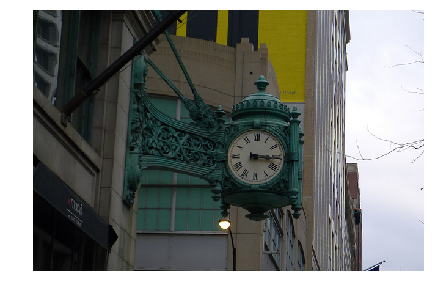

a group of people sitting around a boat


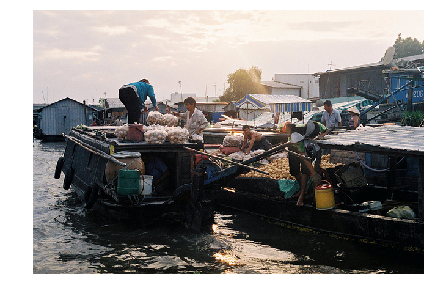

a cat sitting on a couch with a stuffed bear


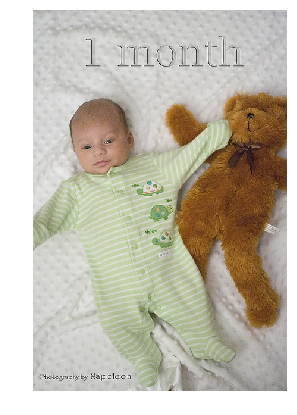

a man and woman cutting a cake with a knife


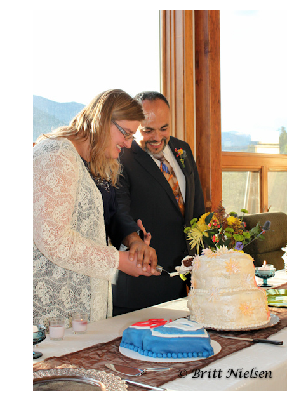

a bathroom with a toilet and a sink


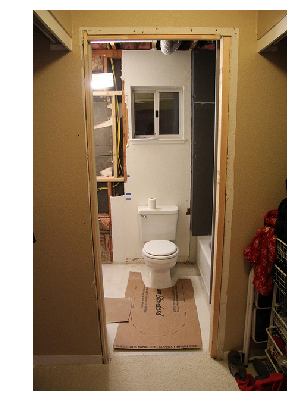

a man and a woman standing on a sidewalk


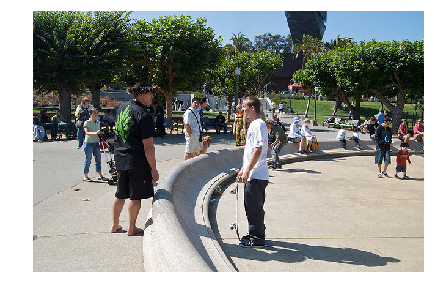

a cat sitting on top of a chair next to a car


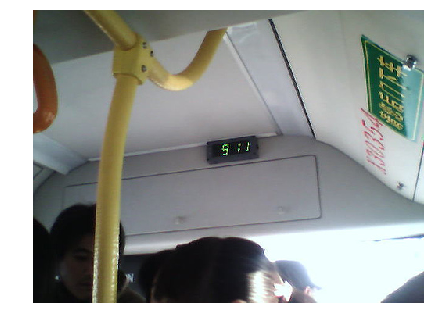

In [49]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

--2019-12-28 22:41:07--  https://static-ssl.businessinsider.com/image/5cbf50dfd1a2f8074406a8b2-2018/shutterstock439368427.jp2
Resolving static-ssl.businessinsider.com (static-ssl.businessinsider.com)... 151.101.49.171
Connecting to static-ssl.businessinsider.com (static-ssl.businessinsider.com)|151.101.49.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525936 (514K) [image/png]
Saving to: 'shutterstock439368427.jp2.1'

shutterstock4393684 100%[===================>] 513.61K  1.60MB/s    in 0.3s    

2019-12-28 22:41:08 (1.60 MB/s) - 'shutterstock439368427.jp2.1' saved [525936/525936]

a boat docked in a harbor with a large ship


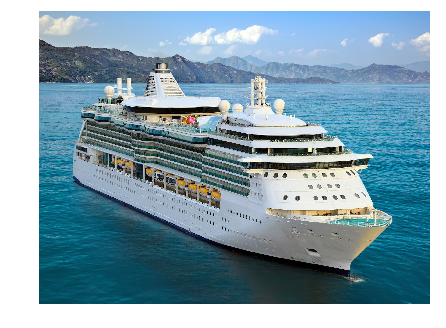

In [54]:
!wget https://static-ssl.businessinsider.com/image/5cbf50dfd1a2f8074406a8b2-2018/shutterstock439368427.jp2
apply_model_to_image_raw_bytes(open("shutterstock439368427.jp2", "rb").read())

--2019-12-28 22:42:11--  https://i.pinimg.com/originals/58/8e/d7/588ed7ea046ce5cb0dc104ff5564af57.png
Resolving i.pinimg.com (i.pinimg.com)... 23.41.25.29, 2600:141c:c000:184::1931, 2600:141c:c000:187::1931
Connecting to i.pinimg.com (i.pinimg.com)|23.41.25.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1364743 (1.3M) [image/png]
Saving to: '588ed7ea046ce5cb0dc104ff5564af57.png'

588ed7ea046ce5cb0dc 100%[===================>]   1.30M  3.56MB/s    in 0.4s    

2019-12-28 22:42:11 (3.56 MB/s) - '588ed7ea046ce5cb0dc104ff5564af57.png' saved [1364743/1364743]

a group of people standing next to each other


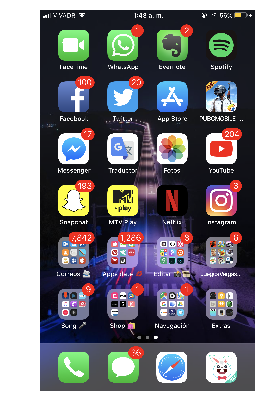

In [56]:
!wget https://i.pinimg.com/originals/58/8e/d7/588ed7ea046ce5cb0dc104ff5564af57.png
apply_model_to_image_raw_bytes(open("588ed7ea046ce5cb0dc104ff5564af57.png", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

--2019-12-28 22:45:34--  https://api.time.com/wp-content/uploads/2019/08/mocking_spongebob.jpg
Resolving api.time.com (api.time.com)... 192.0.66.64, 2a04:fa87:fffd::c000:4240
Connecting to api.time.com (api.time.com)|192.0.66.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47360 (46K) [image/jpeg]
Saving to: 'mocking_spongebob.jpg'

mocking_spongebob.j 100%[===================>]  46.25K  --.-KB/s    in 0.08s   

2019-12-28 22:45:35 (560 KB/s) - 'mocking_spongebob.jpg' saved [47360/47360]

a cake with a pair of scissors and a pair of scissors


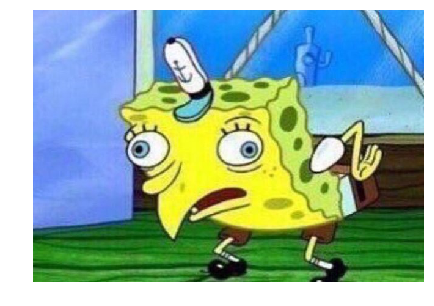

In [59]:
!wget https://api.time.com/wp-content/uploads/2019/08/mocking_spongebob.jpg
apply_model_to_image_raw_bytes(open("mocking_spongebob.jpg", "rb").read())


--2019-12-28 22:46:38--  https://dalecine.com/wp-content/uploads/2017/08/IMG-20170411-WA0011-1.jpg
Resolving dalecine.com (dalecine.com)... 104.24.117.42, 104.24.116.42, 2606:4700:30::6818:742a, ...
Connecting to dalecine.com (dalecine.com)|104.24.117.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194363 (190K) [image/jpeg]
Saving to: 'IMG-20170411-WA0011-1.jpg'

IMG-20170411-WA0011 100%[===================>] 189.81K  1.06MB/s    in 0.2s    

2019-12-28 22:46:39 (1.06 MB/s) - 'IMG-20170411-WA0011-1.jpg' saved [194363/194363]

a man with a beard and a cell phone


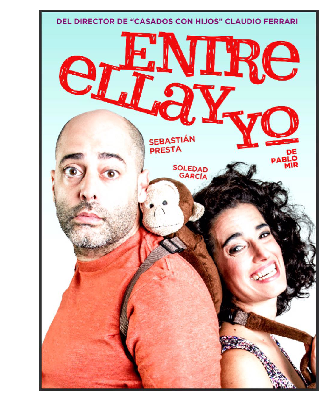

In [60]:
!wget https://dalecine.com/wp-content/uploads/2017/08/IMG-20170411-WA0011-1.jpg
apply_model_to_image_raw_bytes(open("IMG-20170411-WA0011-1.jpg", "rb").read())

--2019-12-28 22:50:16--  https://scm-assets.constant.co/scm/unilever/a6798e909fa57bfd19c3e7f00737e5d6/da9dcad5-93e1-41bf-b846-95e9c93a2632.jpg
Resolving scm-assets.constant.co (scm-assets.constant.co)... 151.101.198.133
Connecting to scm-assets.constant.co (scm-assets.constant.co)|151.101.198.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29548 (29K) [image/jpeg]
Saving to: 'da9dcad5-93e1-41bf-b846-95e9c93a2632.jpg.1'

da9dcad5-93e1-41bf- 100%[===================>]  28.86K  --.-KB/s    in 0.06s   

2019-12-28 22:50:16 (460 KB/s) - 'da9dcad5-93e1-41bf-b846-95e9c93a2632.jpg.1' saved [29548/29548]

a sandwich with a sandwich and a pickle on a plate


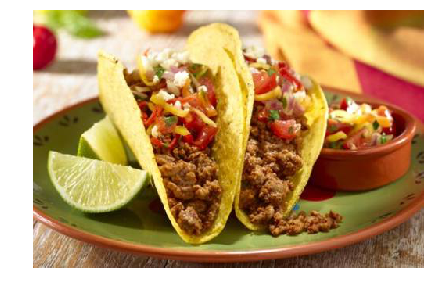

In [62]:
!wget https://scm-assets.constant.co/scm/unilever/a6798e909fa57bfd19c3e7f00737e5d6/da9dcad5-93e1-41bf-b846-95e9c93a2632.jpg
apply_model_to_image_raw_bytes(open("da9dcad5-93e1-41bf-b846-95e9c93a2632.jpg", "rb").read())

--2019-12-28 22:51:19--  https://www.yogawinetravel.com/wp-content/uploads/2016/05/Duomo-in-Florence-Italy_feature.jpg
Resolving www.yogawinetravel.com (www.yogawinetravel.com)... 104.31.65.154, 104.31.64.154, 2606:4700:30::681f:409a, ...
Connecting to www.yogawinetravel.com (www.yogawinetravel.com)|104.31.65.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744167 (727K) [image/jpeg]
Saving to: 'Duomo-in-Florence-Italy_feature.jpg'

Duomo-in-Florence-I 100%[===================>] 726.73K  2.16MB/s    in 0.3s    

2019-12-28 22:51:20 (2.16 MB/s) - 'Duomo-in-Florence-Italy_feature.jpg' saved [744167/744167]

a large clock tower with a clock tower


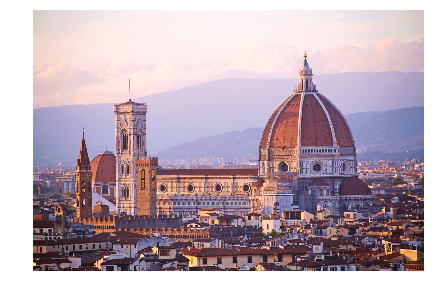

In [63]:
!wget https://www.yogawinetravel.com/wp-content/uploads/2016/05/Duomo-in-Florence-Italy_feature.jpg
apply_model_to_image_raw_bytes(open("Duomo-in-Florence-Italy_feature.jpg", "rb").read())

--2019-12-28 22:54:27--  https://1.bp.blogspot.com/-k_Mvs7B4WfA/Vz9LAklZnFI/AAAAAAAAA1I/htTehpNj8zcJuiNefIEy4Plh4tTH8uu8ACK4B/s1600/26422318934_7b30f3a769_o.jpg
Resolving 1.bp.blogspot.com (1.bp.blogspot.com)... 172.217.15.1, 2607:f8b0:4012:80a::2001
Connecting to 1.bp.blogspot.com (1.bp.blogspot.com)|172.217.15.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217128 (212K) [image/jpeg]
Saving to: '26422318934_7b30f3a769_o.jpg'

26422318934_7b30f3a 100%[===================>] 212.04K  --.-KB/s    in 0.07s   

2019-12-28 22:54:28 (3.17 MB/s) - '26422318934_7b30f3a769_o.jpg' saved [217128/217128]

a group of people sitting around a table with a woman


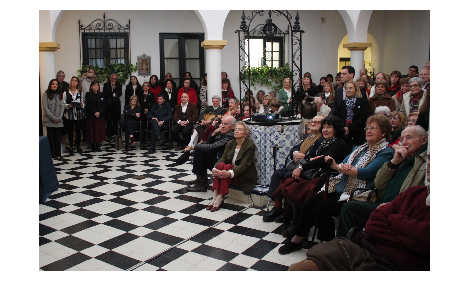

In [64]:
!wget https://1.bp.blogspot.com/-k_Mvs7B4WfA/Vz9LAklZnFI/AAAAAAAAA1I/htTehpNj8zcJuiNefIEy4Plh4tTH8uu8ACK4B/s1600/26422318934_7b30f3a769_o.jpg
apply_model_to_image_raw_bytes(open("26422318934_7b30f3a769_o.jpg", "rb").read())


--2019-12-28 22:55:56--  https://blog.selfbank.es/wp-content/uploads/2018/04/iStock-636337794-1-1-720x320.jpg
Resolving blog.selfbank.es (blog.selfbank.es)... 195.42.250.47
Connecting to blog.selfbank.es (blog.selfbank.es)|195.42.250.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36905 (36K) [image/jpeg]
Saving to: 'iStock-636337794-1-1-720x320.jpg'

iStock-636337794-1- 100%[===================>]  36.04K  69.9KB/s    in 0.5s    

2019-12-28 22:55:58 (69.9 KB/s) - 'iStock-636337794-1-1-720x320.jpg' saved [36905/36905]

a bed with a bed and a window


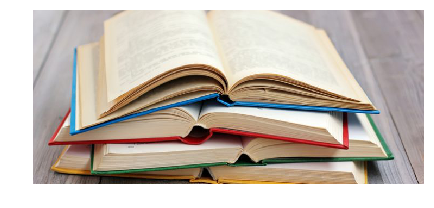

In [65]:
!wget https://blog.selfbank.es/wp-content/uploads/2018/04/iStock-636337794-1-1-720x320.jpg
apply_model_to_image_raw_bytes(open("iStock-636337794-1-1-720x320.jpg", "rb").read())


--2019-12-28 22:57:11--  https://miro.medium.com/max/792/1*126sHZF_Xo8TVuk6ybWnlA.png
Resolving miro.medium.com (miro.medium.com)... 104.16.121.145, 104.16.119.145, 104.16.117.145, ...
Connecting to miro.medium.com (miro.medium.com)|104.16.121.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23404 (23K) [image/png]
Saving to: '1*126sHZF_Xo8TVuk6ybWnlA.png'

1*126sHZF_Xo8TVuk6y 100%[===================>]  22.86K  --.-KB/s    in 0.009s  

2019-12-28 22:57:11 (2.44 MB/s) - '1*126sHZF_Xo8TVuk6ybWnlA.png' saved [23404/23404]

a man sitting at a table with a laptop


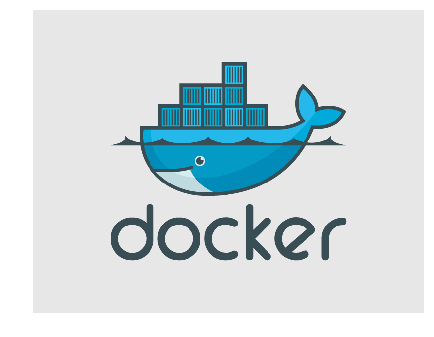

In [66]:
!wget https://miro.medium.com/max/792/1*126sHZF_Xo8TVuk6ybWnlA.png
apply_model_to_image_raw_bytes(open("1*126sHZF_Xo8TVuk6ybWnlA.png", "rb").read())

--2019-12-28 22:58:24--  https://as01.epimg.net/argentina/imagenes/2018/12/10/futbol/1544424453_741659_1544424598_noticia_normal.jpg
Resolving as01.epimg.net (as01.epimg.net)... 189.247.162.8, 189.247.162.58
Connecting to as01.epimg.net (as01.epimg.net)|189.247.162.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80452 (79K) [image/jpeg]
Saving to: '1544424453_741659_1544424598_noticia_normal.jpg'

1544424453_741659_1 100%[===================>]  78.57K  --.-KB/s    in 0.02s   

2019-12-28 22:58:25 (3.54 MB/s) - '1544424453_741659_1544424598_noticia_normal.jpg' saved [80452/80452]

a man and woman standing in a room with a woman


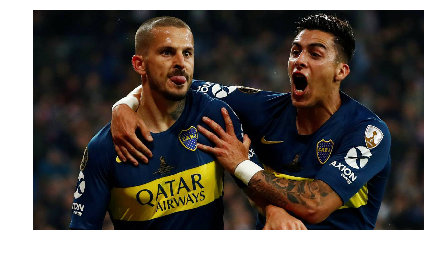

In [67]:
!wget https://as01.epimg.net/argentina/imagenes/2018/12/10/futbol/1544424453_741659_1544424598_noticia_normal.jpg
apply_model_to_image_raw_bytes(open("1544424453_741659_1544424598_noticia_normal.jpg", "rb").read())

--2019-12-28 23:10:00--  https://www.orangesmile.com/common/img_cities_original/boston-20061717-14.jpg
Resolving www.orangesmile.com (www.orangesmile.com)... 65.181.120.52
Connecting to www.orangesmile.com (www.orangesmile.com)|65.181.120.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303764 (297K) [image/jpeg]
Saving to: 'boston-20061717-14.jpg'

boston-20061717-14. 100%[===================>] 296.64K   107KB/s    in 2.8s    

2019-12-28 23:10:04 (107 KB/s) - 'boston-20061717-14.jpg' saved [303764/303764]

a large body of water with a clock tower


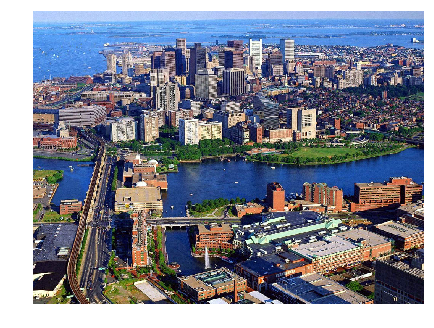

In [69]:
!wget https://www.orangesmile.com/common/img_cities_original/boston-20061717-14.jpg
apply_model_to_image_raw_bytes(open("boston-20061717-14.jpg", "rb").read())

--2019-12-28 23:13:06--  https://i1.wp.com/www.sopitas.com/wp-content/uploads/2018/10/boca-juniors-aficionados-pintar-mural-bombonera-1110x580.png
Resolving i1.wp.com (i1.wp.com)... 192.0.77.2
Connecting to i1.wp.com (i1.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1358616 (1.3M) [image/png]
Saving to: 'boca-juniors-aficionados-pintar-mural-bombonera-1110x580.png'

boca-juniors-aficio 100%[===================>]   1.29M  1.94MB/s    in 0.7s    

2019-12-28 23:13:07 (1.94 MB/s) - 'boca-juniors-aficionados-pintar-mural-bombonera-1110x580.png' saved [1358616/1358616]

a man on a skateboard on a beach


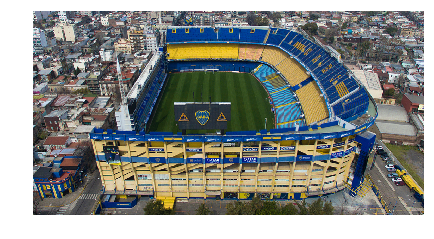

In [77]:
!wget https://i1.wp.com/www.sopitas.com/wp-content/uploads/2018/10/boca-juniors-aficionados-pintar-mural-bombonera-1110x580.png
apply_model_to_image_raw_bytes(open("boca-juniors-aficionados-pintar-mural-bombonera-1110x580.png", "rb").read())

--2019-12-28 23:18:51--  https://blog.storicard.com/wp-content/uploads/2019/07/Aprende-a-utilizar-tu-Tarjeta-de-Credito-Stori.jpg
Resolving blog.storicard.com (blog.storicard.com)... 52.45.222.141, 3.94.40.219
Connecting to blog.storicard.com (blog.storicard.com)|52.45.222.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12022 (12K) [image/jpeg]
Saving to: 'Aprende-a-utilizar-tu-Tarjeta-de-Credito-Stori.jpg'

Aprende-a-utilizar- 100%[===================>]  11.74K  --.-KB/s    in 0s      

2019-12-28 23:18:51 (75.6 MB/s) - 'Aprende-a-utilizar-tu-Tarjeta-de-Credito-Stori.jpg' saved [12022/12022]

a wii remote control sitting on top of a table


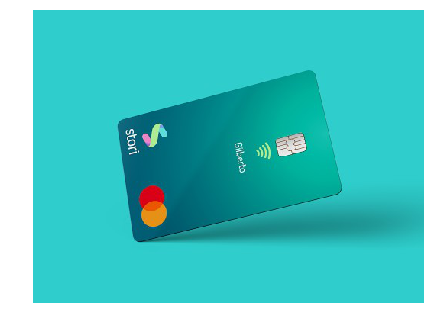

In [78]:
!wget https://blog.storicard.com/wp-content/uploads/2019/07/Aprende-a-utilizar-tu-Tarjeta-de-Credito-Stori.jpg
apply_model_to_image_raw_bytes(open("Aprende-a-utilizar-tu-Tarjeta-de-Credito-Stori.jpg", "rb").read())

--2019-12-28 23:20:16--  https://www.microsoft.com/es-es/microsoft-365/blog/wp-content/uploads/sites/26/2019/01/OfficeNews_365Mac-440x268.png
Resolving www.microsoft.com (www.microsoft.com)... 23.41.26.57, 2600:141c:c000:180::356e, 2600:141c:c000:182::356e
Connecting to www.microsoft.com (www.microsoft.com)|23.41.26.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200076 (195K) [image/png]
Saving to: 'OfficeNews_365Mac-440x268.png'

OfficeNews_365Mac-4 100%[===================>] 195.39K   597KB/s    in 0.3s    

2019-12-28 23:20:17 (597 KB/s) - 'OfficeNews_365Mac-440x268.png' saved [200076/200076]

a man sitting at a table with a laptop computer


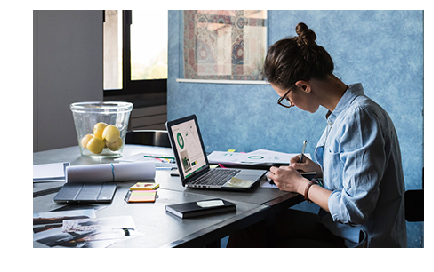

In [79]:
!wget https://www.microsoft.com/es-es/microsoft-365/blog/wp-content/uploads/sites/26/2019/01/OfficeNews_365Mac-440x268.png
apply_model_to_image_raw_bytes(open("OfficeNews_365Mac-440x268.png", "rb").read())

--2019-12-28 23:21:33--  https://www.aqueenofmagic.com/wp-content/uploads/2019/07/Freddie-Mercury-Performing-at-Live-Aid-1985-678x381.jpg
Resolving www.aqueenofmagic.com (www.aqueenofmagic.com)... 37.152.88.89
Connecting to www.aqueenofmagic.com (www.aqueenofmagic.com)|37.152.88.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28256 (28K) [image/jpeg]
Saving to: 'Freddie-Mercury-Performing-at-Live-Aid-1985-678x381.jpg.1'

Freddie-Mercury-Per 100%[===================>]  27.59K  96.3KB/s    in 0.3s    

2019-12-28 23:21:34 (96.3 KB/s) - 'Freddie-Mercury-Performing-at-Live-Aid-1985-678x381.jpg.1' saved [28256/28256]

a man holding a tennis racket and a woman in the background


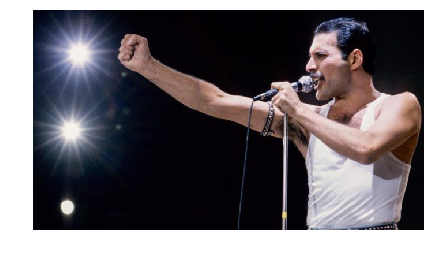

In [81]:
!wget https://www.aqueenofmagic.com/wp-content/uploads/2019/07/Freddie-Mercury-Performing-at-Live-Aid-1985-678x381.jpg
apply_model_to_image_raw_bytes(open("Freddie-Mercury-Performing-at-Live-Aid-1985-678x381.jpg", "rb").read())

a woman and woman standing next to each other


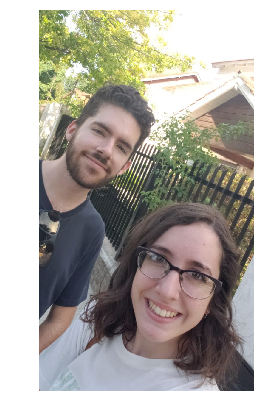

a man holding a cell phone in front of a mirror


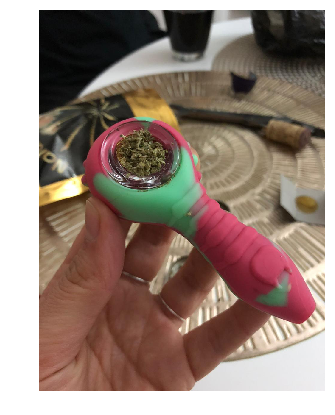

a large green and white cat sitting on a wooden bench


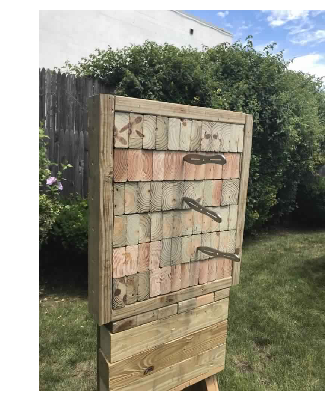

a man and woman are standing in the grass


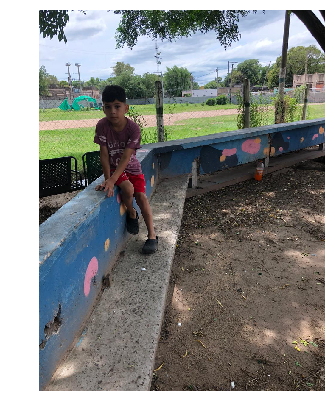

a man in a boat is sitting on a boat


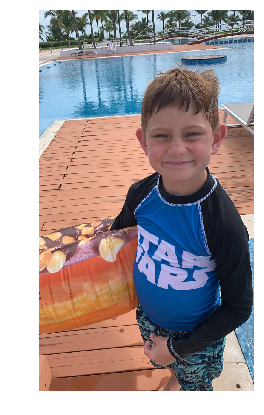

a man sitting at a table with a cake


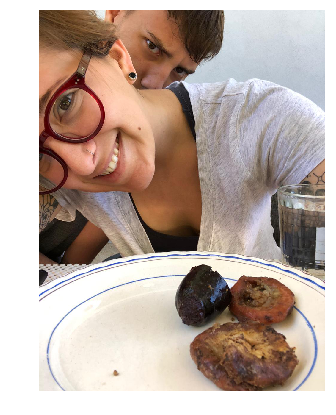

a man holding a bottle of wine and a bottle of wine


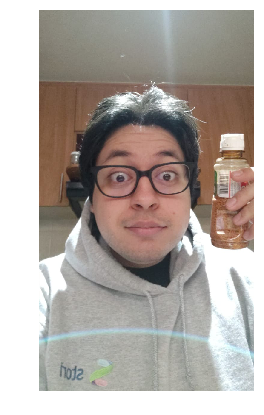

a dog sitting on top of a chair with a dog


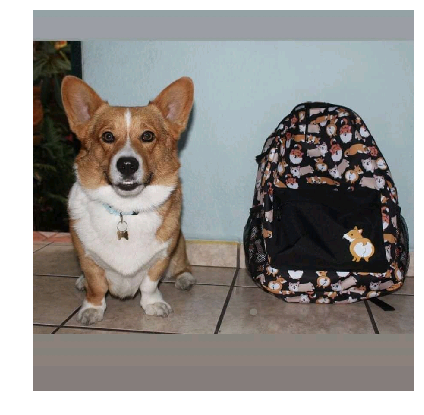

In [41]:
local_files = ('janer.jpeg','mota.jpeg', 'cuchis.jpeg', 'villa.jpeg', 'benja.jpeg', 'chinchu.jpeg', 'luis.jpeg',
              'claudia.jpeg')
for i in local_files:
    apply_model_to_image_raw_bytes(open(i, "rb").read())


In [83]:
!pwd

/root/intro-to-dl/week6


That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!